# Getting the data

## Download the MNIST dataset

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

The `data` key contains the features of the image, which is a 28 x 28 (784px) bitmap of 0 and 1. The `target` key contains the labels, i.e. the digit that represent the image

In [2]:
x,y = mnist["data"], mnist["target"]
print("x shape =", x.shape, "y shape =", y.shape)

x shape = (70000, 784) y shape = (70000,)


Use `imshow` to convert a array of pixels to an actual image

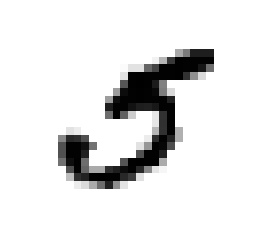

In [15]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = x[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

The image above looks like a "5" and indeed it is a 5:

In [14]:
y[36000]

5.0

## Always create a test and trainset

Fortunately, SKLearn has done that for us. The first 60000 data points are the trainset, containing a roughly equal number of images of digits 0 - 9

In [5]:
import numpy as np

x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

# Shuffle the sets so the algorithm do not get several same
# digits in a row which could degrade performance
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# Training a binary classifier
Let's simplify the problem by trying to identify only one digit, for example, 5. This is an example of a binary classifier, capable of distinguishing just two classes, 5 and not-5

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for everything else
y_test_5 = (y_test == 5)

In [21]:
# Train it using the Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=10)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

# Performance Measure
Evaluating a classifier is often significantly trickier than a regressor. Let's start with an old tool: the cross validator

## Measuring accuracy using cross validation
Recall that K-fold cross-validation means splitting the training set into K subsets (i.e. folds) and making prediction and scoring them on fold. Let use `K = 3`

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.957 ,  0.9636,  0.9653])

The 95% score looks good, but there's more than meet the eyes. Let's write a very dumb classifier that classifies every image into the "not-5" class:

In [35]:
from sklearn.base import BaseEstimator

class NeverClassifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)
    
never_5_clf = NeverClassifier()
cross_val_score(never_5_clf, x_train, y_train, cv=3, scoring="accuracy")

array([ 0.0961 ,  0.1003 ,  0.09975])

Wow, 90% accuracy for a garbage classifier! That's because only 10% of the training set is 5. The other 90% is not-5. So even with a garbage classifier, you are still corect 90% of the time. This demonstrates that **accuracy is often not the preferred performance measure** for classifiers, especially when you are dealing with skwed datasets, when some classes appear much more frequently than others.

## Confusion Matrix
A confusion matrix counts the number of times an instance of class A was misidentifier as an instance of class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look into the 5th row and 3rd column of the matrix.

The `cross_val_predict` function divides the set into smaller subsets and make clean predictions on each subset. Clean meaning the prediction is made by a model that never saw the data during training

In [47]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

Here's how to intepret the confusion matrix:
* The first row and first column contains the not-5 (the False/Negative class)
* The second row and second column contains the is-5 (the True/Positive class)
* 53,814 images are not-5 and correctly classified so (true negatives)
* 765 images are not-5 but incorrectly classified as is-5 (false positives)
* 1,517 are 5 but wrongly classified as not-5 (true positives)
* 3,904 are 5 and correctly classified as such (false negatives)

A perfect classifier would have only the diagonals and 0 for all other cells

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53814,   765],
       [ 1517,  3904]])

You may prefer some more concise metrics:

$$
\begin{align}
\text{precision} &= \frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}} \\\\
\text{recall}    &= \frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}
\end{align}
$$

* precision alone is not enough because if you make one only one TP and no FP have perfect precision
* recall (a.k.a sensitivity or true positive rate) is the ratio of positive instances that are correctly detected by the classifier

You do not have to create your own implementation of precision and recall. SKLearn already provides them:

In [49]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.83615335189548079

In [50]:
recall_score(y_train_5, y_train_pred)

0.72016233167312305

Now the classifier doesn't look as good as it was. It only detects a 5 correctly 84% of the times, and only found 72% of the 5s.

It's often convenient to combine the precision and recall into a single metric called $F_1$ score if you need a metric to compare 2 classifiers. $F_1$ is the harmonic mean of precision and recall:

$$
F_1 = 2 \div \left( \frac{1}{\text{precision}} + \frac{1}{\text{recall}} \right)
$$

Or call the `f1_score()` function from SKLearn:

In [51]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77383548067393448

The $F_1$ score tends to favour classifiers with similar precision and recall. Sometimes you may prefer one of the other. For example:
* If you train a video classifier to filter videos that are safe for kids, you would prefer a high-precision (fewer "bad" videos); a low-recall rate (more "good" videos marked as unsafe) would be acceptable
* If you train a video classifier to catch shop-lifter, you would accept a low-precision (more shoppers tagged as suspects) to favour high-recall (more actual thieves will be tagged)

Unfortunately, you can't have it both way. Increasing one reduces the other. This is called the *precision/recall tradeoff*